In [244]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC





# Preprocessing

In [245]:
hfcr = pd.read_csv('heart_failure_clinical_records_dataset.csv')
hfcr.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [246]:
hfcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


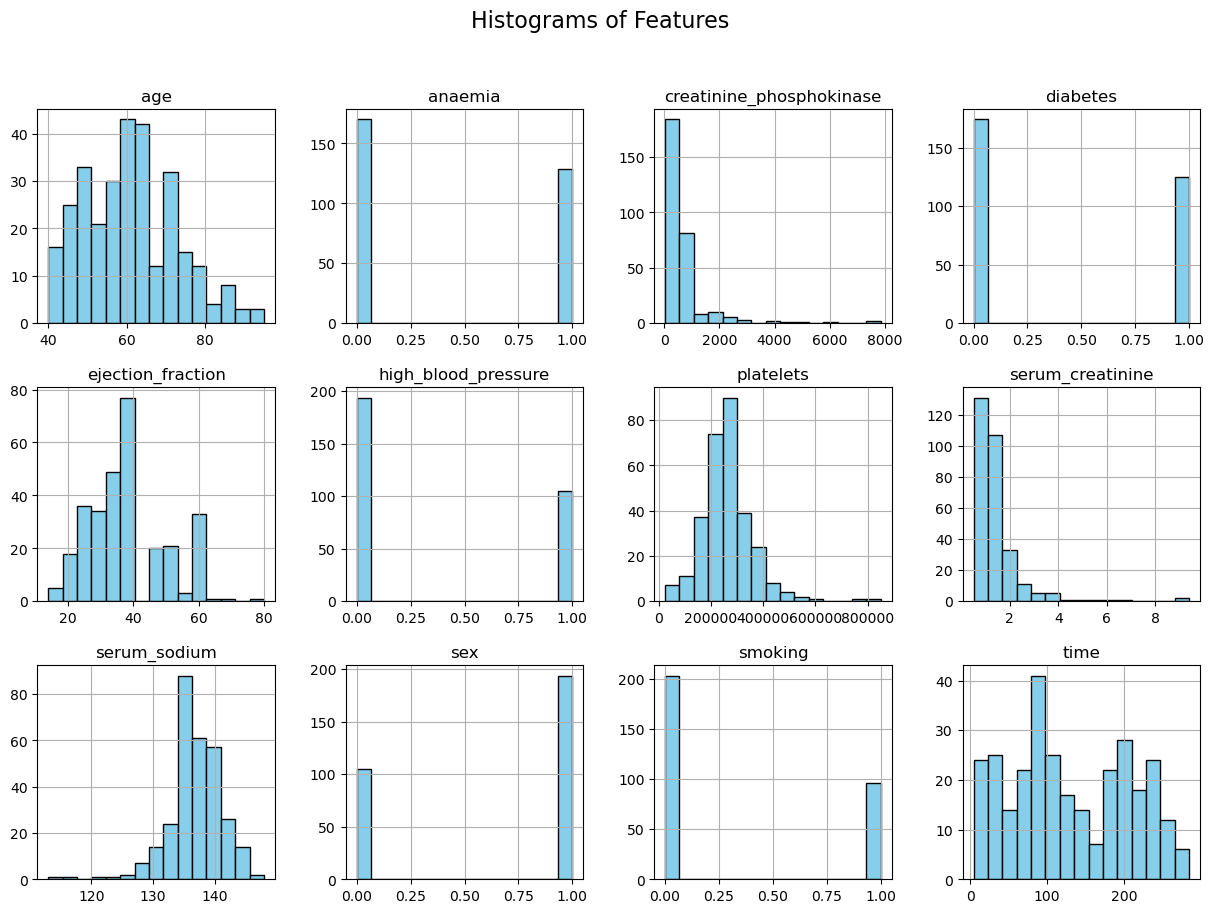

In [247]:
hfcr.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()



In [248]:
binary_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
continuous_features_standardize = ["age", "ejection_fraction", "serum_sodium", "time"]
continuous_features_normalize = ["creatinine_phosphokinase", "platelets", "serum_creatinine"]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = hfcr[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(hfcr[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(hfcr[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = hfcr['DEATH_EVENT']

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

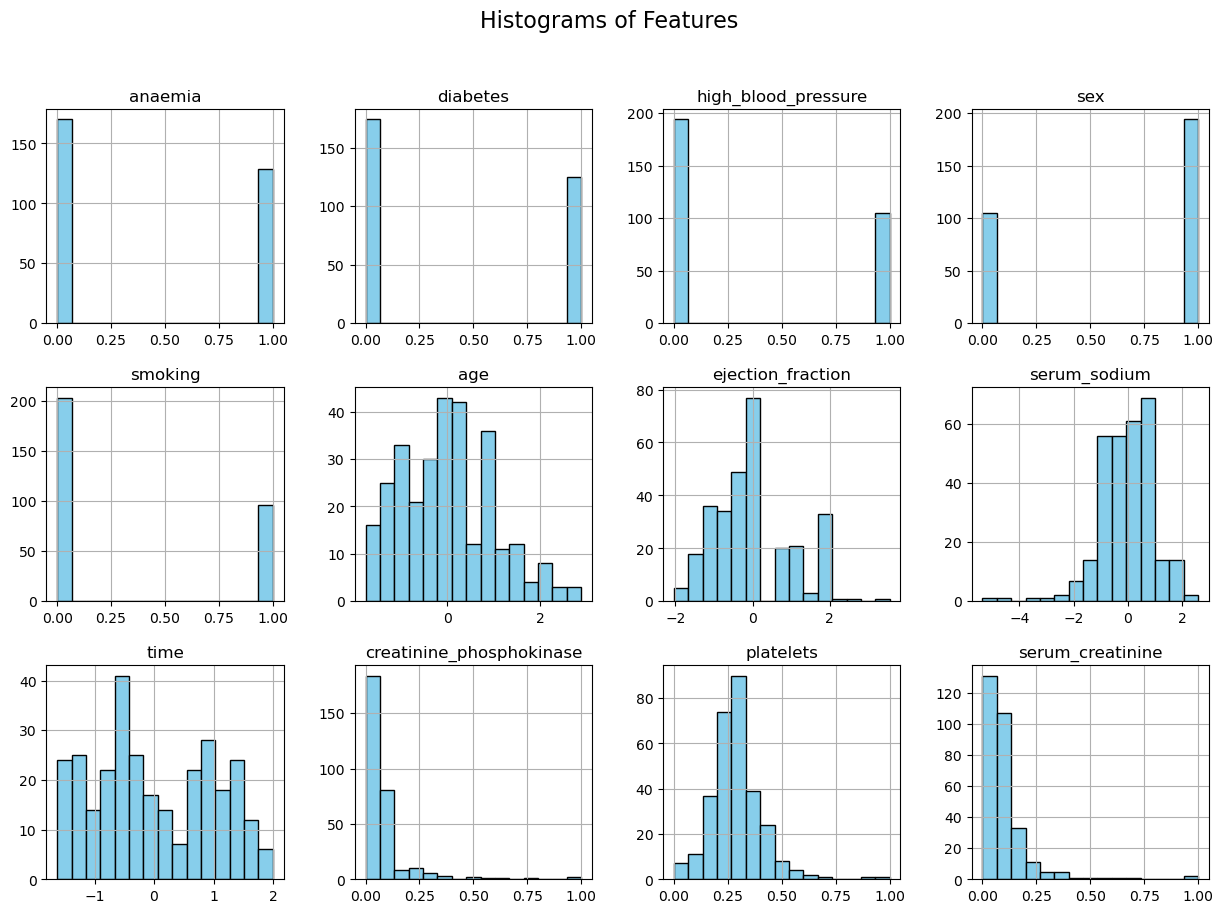

In [249]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()




#print(target.head())
#print(features.head())

In [250]:
features = processed_data.iloc[:,:-1]
target = processed_data.iloc[:,12]
#print(features.head())
#print(target.head())

In [251]:
# check for imbalances
target_counts = pd.Series(target).value_counts()
print(target_counts)

0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [252]:
features.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,299.000000,299.000000,299.000000,299.000000,299.00000,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,299.000000,299.000000,299.000000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,5.703353e-16,-3.267546e-17,-8.673849e-16,-1.901118e-16,0.071299,0.288833,0.100436
std,0.496107,0.494067,0.478136,0.478136,0.46767,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,0.123793,0.118565,0.116237
min,0.000000,0.000000,0.000000,0.000000,0.00000,-1.754448e+00,-2.038387e+00,-5.363206e+00,-1.629502e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,-8.281242e-01,-6.841802e-01,-5.959961e-01,-7.389995e-01,0.011929,0.227179,0.044944
50%,0.000000,0.000000,0.000000,1.000000,0.00000,-7.022315e-02,-7.076750e-03,8.503384e-02,-1.969543e-01,0.028961,0.287186,0.067416
75%,1.000000,1.000000,1.000000,1.000000,1.00000,7.718891e-01,5.853888e-01,7.660638e-01,9.387595e-01,0.071319,0.337495,0.101124
max,1.000000,1.000000,1.000000,1.000000,1.00000,2.877170e+00,3.547716e+00,2.582144e+00,1.997038e+00,1.000000,1.000000,1.000000


In [253]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)

features_re, target_re = smote.fit_resample(features,target)

In [254]:
# check for imbalances
target_counts = pd.Series(target_re).value_counts()
print(target_counts)

1    203
0    203
Name: DEATH_EVENT, dtype: int64


In [255]:
features_re.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,0.396552,0.381773,0.332512,0.623153,0.285714,0.084110,-0.111512,-0.047144,-0.205336,0.075691,0.284536,0.113752
std,0.489785,0.486421,0.471695,0.485194,0.452311,1.012207,1.006150,1.011068,1.000424,0.129870,0.110334,0.127031
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.754448,-2.038387,-5.363206,-1.629502,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.738433,-0.910013,-0.595996,-1.122948,0.012987,0.224148,0.056180
50%,0.000000,0.000000,0.000000,1.000000,0.000000,-0.070223,-0.260991,0.079341,-0.438469,0.032258,0.284591,0.078434
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.771889,0.162199,0.539054,0.729040,0.071319,0.335374,0.131884
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.877170,3.547716,2.582144,1.997038,1.000000,1.000000,1.000000


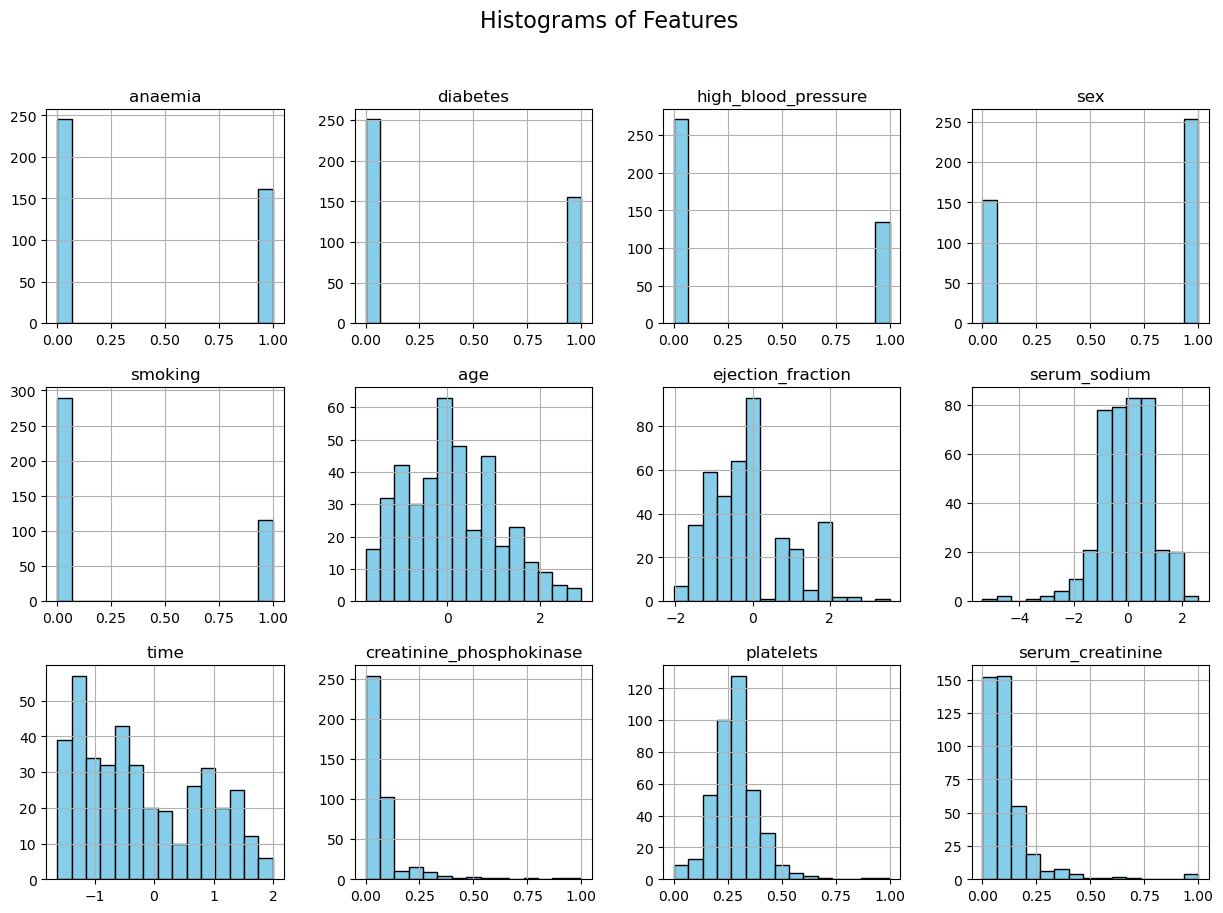

In [256]:
features_re.hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


<Axes: >

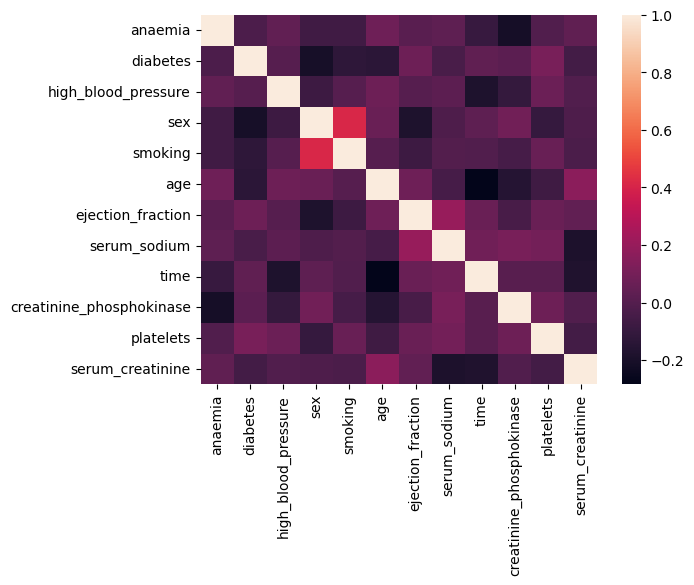

In [257]:
features_corr = features_re.corr()
sns.heatmap(features_corr)

In [816]:
def get_scores(X, Y, split,clf, clf_name, dataset):
    results = []
    acc_per_split = {}
    train_acc = 0
    test_acc = 0



    for i, trial in enumerate(split):



        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=trial, random_state=i)

        param_grid = {
            'LogisticRegression': {'C': [0.001, 0.1, 1, 10, 100, 1000],
                                   'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                                   'max_iter': [1000, 2500, 5000]},
                                   
            'KNeighborsClassifier': {'n_neighbors': [1, 10],
                                     'leaf_size': [1, 20, 40],
                                     'p': [1,2],
                                     'weights': ['uniform', 'distance'],
                                     'metric': ['minkowski', 'chebyshev']},

            'DecisionTreeClassifier': {'max_depth': [3, 5, 10, None],
                                       'min_samples_split': [2, 5, 10],
                                       'criterion': ['gini', 'entropy']},


            'SVM': {'C': [0.001, 0.1, 1, 10, 100, 1000],
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                    'kernel': ['linear', 'rbf']},
            
        }

        grid_search = GridSearchCV(clf, param_grid[clf_name], cv=3)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best = grid_search.best_estimator_
        train_acc += accuracy_score(y_train, best.predict(x_train))
        test_acc +=  accuracy_score(y_test, best.predict(x_test))

        acc_per_split[str(trial *100) + '% testing split'] =  [{'Classifier': clf_name},[accuracy_score(y_train, best.predict(x_train)), accuracy_score(y_test, best.predict(x_test))],best_params]


    train_acc = train_acc/3
    test_acc = test_acc/3
    results = {
        'Dataset': dataset,
        'Classifier': clf_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
    }

    return results, acc_per_split


In [817]:
splits = [0.2, 0.5, 0.8]

# Logistic Regression

In [818]:


results_log_reg_1, acc_log_reg_1 = get_scores(features_re, target_re, splits, clf=LogisticRegression(), clf_name='LogisticRegression', dataset = 'Heart Failure Clinical Records')


In [819]:
print(results_log_reg_1)

{'Dataset': 'Heart Failure Clinical Records', 'Classifier': 'LogisticRegression', 'Train Accuracy': 0.8439578833270934, 'Test Accuracy': 0.8116640191963039}


In [820]:
print(acc_log_reg_1)

{'20.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.8573127229488704, 0.8341232227488151], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '50.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.8555133079847909, 0.8288973384030418], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '80.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.819047619047619, 0.7719714964370546], {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}]}


# KNN

In [821]:
results_knn_1, acc_knn_1 = get_scores(features_re, target_re, splits, clf=KNeighborsClassifier(), clf_name= 'KNeighborsClassifier', dataset = 'Heart Failure Clinical Records')

In [822]:
print(results_knn_1)

{'Dataset': 'Heart Failure Clinical Records', 'Classifier': 'KNeighborsClassifier', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9360972878263776}


In [823]:
print(acc_knn_1)

{'20.0% testing split': [{'Classifier': 'KNeighborsClassifier'}, [1.0, 1.0], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}], '50.0% testing split': [{'Classifier': 'KNeighborsClassifier'}, [1.0, 0.9543726235741445], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}], '80.0% testing split': [{'Classifier': 'KNeighborsClassifier'}, [1.0, 0.8539192399049881], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}]}


# Decision Tree

In [824]:
results_dt_1, acc_dt_1= get_scores(features_re, target_re, splits, clf=DecisionTreeClassifier(), clf_name= 'DecisionTreeClassifier', dataset = 'Heart Failure Clinical Records')

In [825]:
print(results_dt_1)

{'Dataset': 'Heart Failure Clinical Records', 'Classifier': 'DecisionTreeClassifier', 'Train Accuracy': 0.9984126984126984, 'Test Accuracy': 0.9255680090556314}


In [826]:
print(acc_dt_1)

{'20.0% testing split': [{'Classifier': 'DecisionTreeClassifier'}, [1.0, 1.0], {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}], '50.0% testing split': [{'Classifier': 'DecisionTreeClassifier'}, [1.0, 0.9619771863117871], {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}], '80.0% testing split': [{'Classifier': 'DecisionTreeClassifier'}, [0.9952380952380953, 0.8147268408551069], {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}]}


# SVM

In [827]:
results_svm_1, acc_svm_1 = get_scores(features_re, target_re, splits, clf=SVC(), clf_name = 'SVM', dataset = 'Heart Failure Clinical Records')

In [828]:
print(results_svm_1)

{'Dataset': 'Heart Failure Clinical Records', 'Classifier': 'SVM', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9265178267689037}


In [829]:
print(acc_svm_1)

{'20.0% testing split': [{'Classifier': 'SVM'}, [1.0, 1.0], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}], '50.0% testing split': [{'Classifier': 'SVM'}, [1.0, 0.9600760456273765], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}], '80.0% testing split': [{'Classifier': 'SVM'}, [1.0, 0.8194774346793349], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}]}


# DATASET #2

In [830]:
pd_hrt = pd.read_csv('heart.dat', delim_whitespace=True, header=None)
print(pd_hrt)

       0    1    2      3      4    5    6      7    8    9    10   11   12  \
0    70.0  1.0  4.0  130.0  322.0  0.0  2.0  109.0  0.0  2.4  2.0  3.0  3.0   
1    67.0  0.0  3.0  115.0  564.0  0.0  2.0  160.0  0.0  1.6  2.0  0.0  7.0   
2    57.0  1.0  2.0  124.0  261.0  0.0  0.0  141.0  0.0  0.3  1.0  0.0  7.0   
3    64.0  1.0  4.0  128.0  263.0  0.0  0.0  105.0  1.0  0.2  2.0  1.0  7.0   
4    74.0  0.0  2.0  120.0  269.0  0.0  2.0  121.0  1.0  0.2  1.0  1.0  3.0   
..    ...  ...  ...    ...    ...  ...  ...    ...  ...  ...  ...  ...  ...   
265  52.0  1.0  3.0  172.0  199.0  1.0  0.0  162.0  0.0  0.5  1.0  0.0  7.0   
266  44.0  1.0  2.0  120.0  263.0  0.0  0.0  173.0  0.0  0.0  1.0  0.0  7.0   
267  56.0  0.0  2.0  140.0  294.0  0.0  2.0  153.0  0.0  1.3  2.0  0.0  3.0   
268  57.0  1.0  4.0  140.0  192.0  0.0  0.0  148.0  0.0  0.4  2.0  0.0  6.0   
269  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   

     13  
0     2  
1     1  
2     2  
3     1  
4

In [831]:
pd_hrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       270 non-null    float64
 1   1       270 non-null    float64
 2   2       270 non-null    float64
 3   3       270 non-null    float64
 4   4       270 non-null    float64
 5   5       270 non-null    float64
 6   6       270 non-null    float64
 7   7       270 non-null    float64
 8   8       270 non-null    float64
 9   9       270 non-null    float64
 10  10      270 non-null    float64
 11  11      270 non-null    float64
 12  12      270 non-null    float64
 13  13      270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


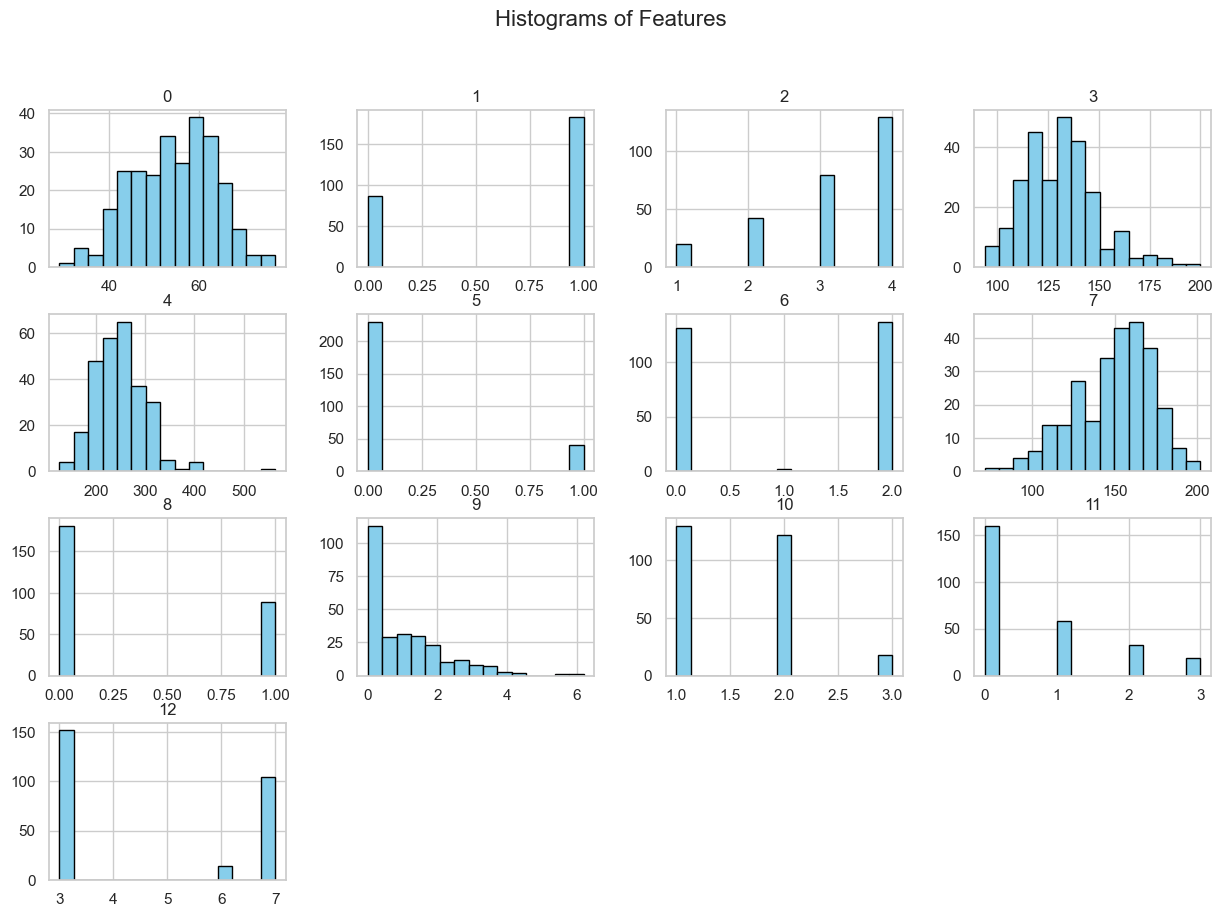

In [832]:
pd_hrt.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


In [833]:
binary_features = [1, 5, 8]
continuous_features_standardize = [0, 3, 4, 6, 7, 10, 12]
continuous_features_normalize = [2, 9, 11]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = pd_hrt[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(pd_hrt[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(pd_hrt[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = pd_hrt.iloc[:, -1]

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

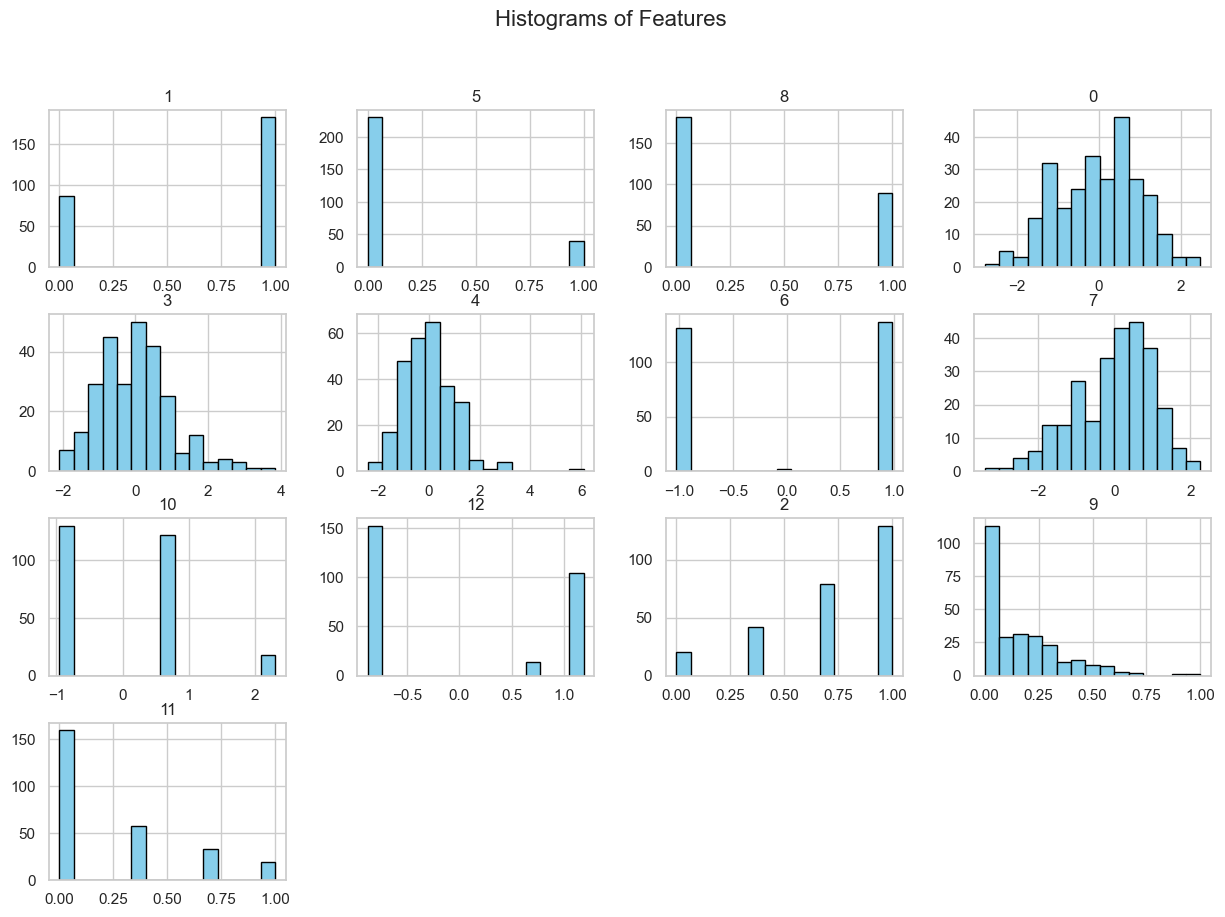

In [834]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


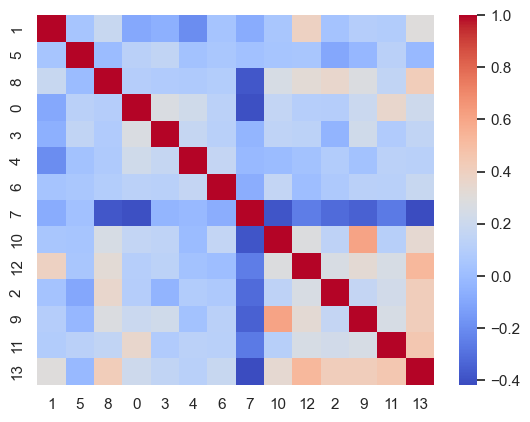

In [835]:
corr_matrix = processed_data.corr()

sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [836]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

1    150
2    120
Name: 13, dtype: int64


In [837]:
features_2 = processed_data.iloc[:, :-1]
target_2 = processed_data.iloc[:, -1]

In [838]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)

features_2, target_2 = smote.fit_resample(features_2,target_2)

In [839]:
target_counts = pd.Series(target_2).value_counts()
print(target_counts)

2    150
1    150
Name: 13, dtype: int64


# Logistic Regression

In [840]:
results_log_reg_2, acc_log_reg_2 = get_scores(features_2, target_2, splits, clf=LogisticRegression(), clf_name='LogisticRegression', dataset = 'Heart Data')


c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [841]:
print(results_log_reg_2)

{'Dataset': 'Heart Data', 'Classifier': 'LogisticRegression', 'Train Accuracy': 0.8488888888888889, 'Test Accuracy': 0.8216666666666667}


In [842]:
print(acc_log_reg_2)

{'20.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.8666666666666667, 0.85], {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}], '50.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.88, 0.84], {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}], '80.0% testing split': [{'Classifier': 'LogisticRegression'}, [0.8, 0.775], {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}]}


# KNN

In [ ]:
results_knn_2, acc_knn_2= get_scores(features_2, target_2, splits, clf=KNeighborsClassifier(), clf_name= 'KNeighborsClassifier', dataset = 'Heart Data')

In [ ]:
print(results_knn_2)

{'Dataset': 'Heart Data', 'Classifier': 'KNeighborsClassifier', 'Train Accuracy': 1.0, 'Test Accuracy': 0.7577777777777778}


In [ ]:
print(acc_knn_2)

{'20.0% testing split': [[1.0, 0.8666666666666667], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}], '50.0% testing split': [[1.0, 0.74], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}], '80.0% testing split': [[1.0, 0.6666666666666666], {'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}]}


# Decision Tree

In [ ]:
results_dt_2, acc_dt_2= get_scores(features_2, target_2, splits, clf=DecisionTreeClassifier(), clf_name= 'DecisionTreeClassifier', dataset = 'Heart Data')

In [ ]:
print(results_dt_2)

{'Dataset': 'Heart Data', 'Classifier': 'DecisionTreeClassifier', 'Train Accuracy': 0.9419444444444444, 'Test Accuracy': 0.7522222222222222}


In [ ]:
print(acc_dt_2)

{'20.0% testing split': [[0.8791666666666667, 0.85], {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}], '50.0% testing split': [[0.9466666666666667, 0.7733333333333333], {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}], '80.0% testing split': [[1.0, 0.6333333333333333], {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}]}


# SVM

In [ ]:
results_svm_2, acc_svm_2= get_scores(features_2, target_2, splits, clf=SVC(), clf_name= 'SVM', dataset = 'Heart Data')

In [ ]:
print(results_svm_2)

{'Dataset': 'Heart Data', 'Classifier': 'SVM', 'Train Accuracy': 0.9155555555555556, 'Test Accuracy': 0.8024999999999999}


In [ ]:
print(acc_svm_2)

{'20.0% testing split': [[0.8666666666666667, 0.8666666666666667], {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}], '50.0% testing split': [[0.88, 0.82], {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}], '80.0% testing split': [[1.0, 0.7208333333333333], {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}]}


# Dataset 3

In [ ]:
spectf = pd.read_csv('SPECTF.train', header= None)

print(spectf.head())
print(spectf.shape)

   0   1   2   3   4   5   6   7   8   9   ...  35  36  37  38  39  40  41  \
0   1  59  52  70  67  73  66  72  61  58  ...  66  56  62  56  72  62  74   
1   1  72  62  69  67  78  82  74  65  69  ...  65  71  63  60  69  73  67   
2   1  71  62  70  64  67  64  79  65  70  ...  73  70  66  65  64  55  61   
3   1  69  71  70  78  61  63  67  65  59  ...  61  61  66  65  72  73  68   
4   1  70  66  61  66  61  58  69  69  72  ...  67  69  70  66  70  64  60   

   42  43  44  
0  74  64  67  
1  71  56  58  
2  41  51  46  
3  68  59  63  
4  55  49  41  

[5 rows x 45 columns]
(80, 45)


In [ ]:
spectf_test = pd.read_csv('SPECTF.test', header= None)

#print(spectf_test.head())
#print(spectf_test.shape)

In [ ]:
spectf_df = pd.concat([spectf, spectf_test], axis = 0)
print(spectf_df.shape)

(267, 45)


In [ ]:
#spectf_df.info()

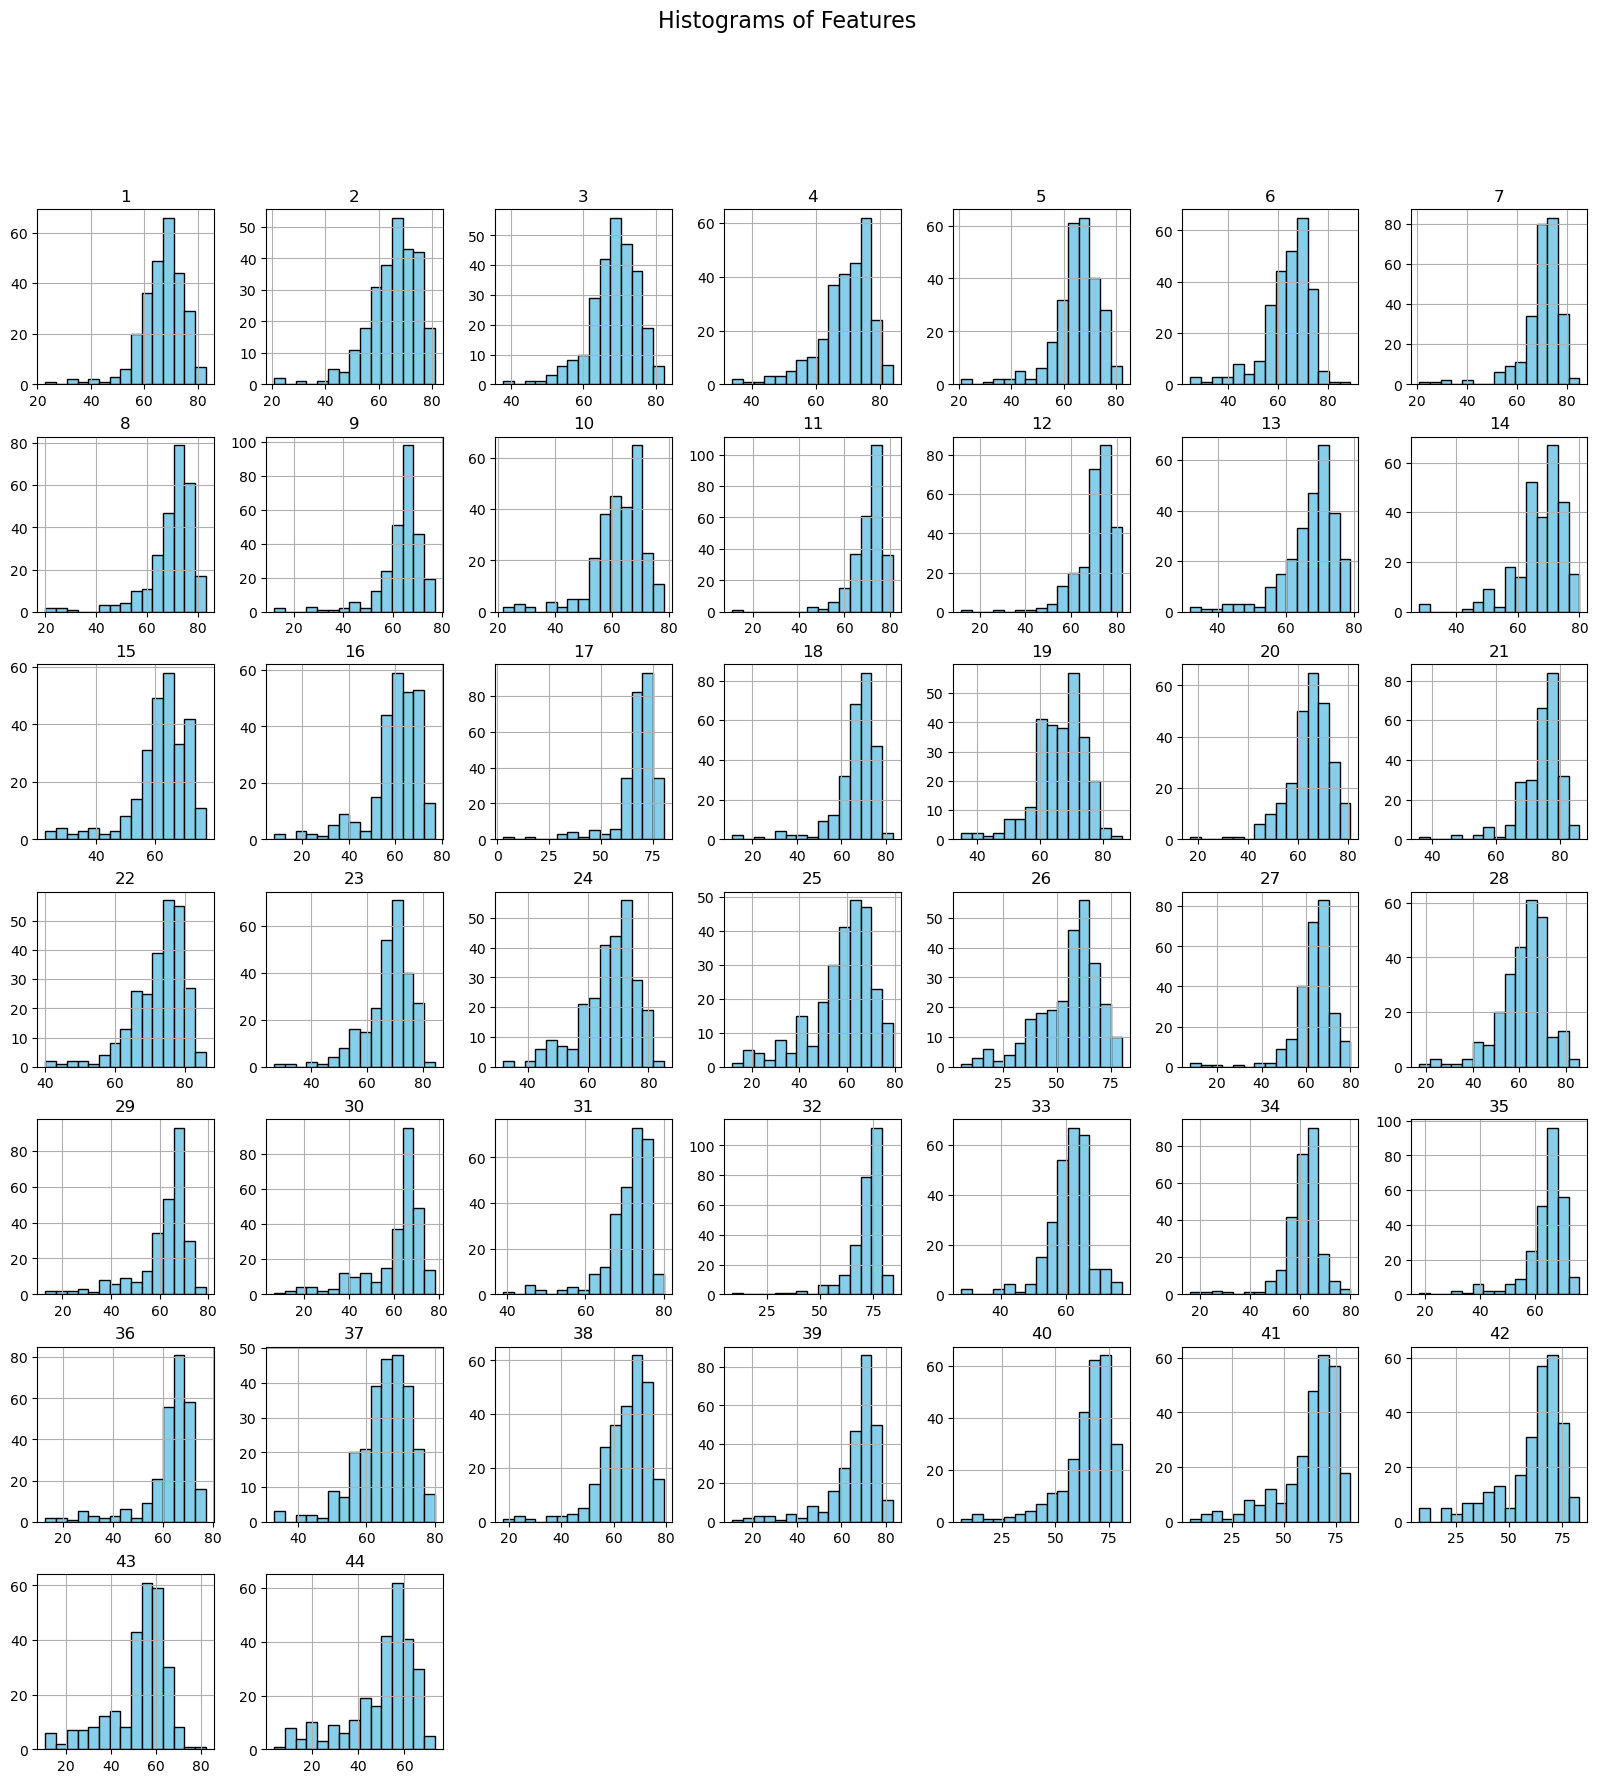

In [ ]:
spectf_df.iloc[:, 1:].hist(bins=15, figsize=(20, 20), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

In [ ]:


scaler = StandardScaler()
data_array = spectf_df.to_numpy()
scaled_data = scaler.fit_transform(data_array[:, 1:])
first_col = data_array[:, 0]


spectf_df_std = np.concatenate((first_col[:, np.newaxis],scaled_data,), axis=1)

spectf_df_std = pd.DataFrame(spectf_df_std)
#print(spectf_df_std.head())



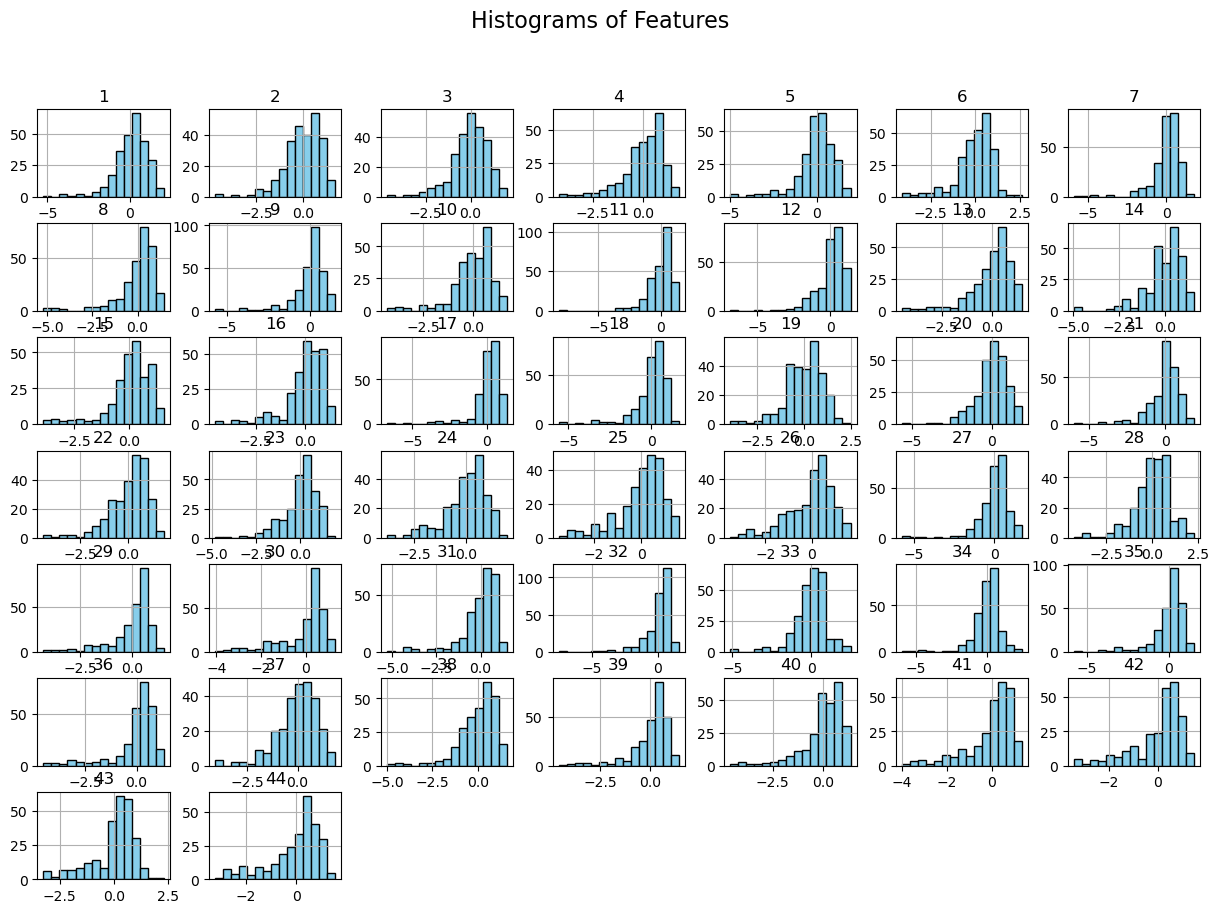

In [ ]:
spectf_df_std.iloc[:, 1:].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


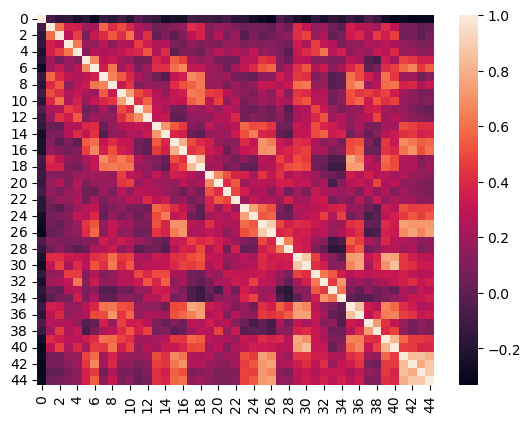

In [ ]:
corr_matrix = spectf_df_std.corr()

sns.heatmap(corr_matrix)
plt.show()

In [ ]:
features = spectf_df_std.iloc[:, 1:]
target = spectf_df_std.iloc[:, 0]

In [ ]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

1.0    212
0.0     55
Name: 0, dtype: int64


In [ ]:
smote = SMOTE(random_state=4)

features, target = smote.fit_resample(features,target)

In [ ]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

1.0    212
0.0    212
Name: 0, dtype: int64


# Logistic Regression

In [ ]:
results_log_reg_3, acc_log_reg_3 = get_scores(features, target, splits, clf=LogisticRegression(), clf_name='LogisticRegression', dataset = 'SPECTF')


c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

In [ ]:
print(results_log_reg_3)

{'Dataset': 'SPECTF', 'Classifier': 'LogisticRegression', 'Train Accuracy': 0.9371778154129132, 'Test Accuracy': 0.8159637439881613}


In [ ]:
print(acc_log_reg_3)

{'20.0% testing split': [[0.9321533923303835, 0.7764705882352941], {'C': 100, 'max_iter': 2500, 'solver': 'saga'}], '50.0% testing split': [[0.9150943396226415, 0.8537735849056604], {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}], '80.0% testing split': [[0.9642857142857143, 0.8176470588235294], {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}]}


# KNN

In [ ]:
results_knn_3, acc_knn_3 = get_scores(features, target, splits, clf=KNeighborsClassifier(), clf_name= 'KNeighborsClassifier', dataset = 'SPECTF')


In [ ]:
print(results_knn_3)

{'Dataset': 'SPECTF', 'Classifier': 'KNeighborsClassifier', 'Train Accuracy': 1.0, 'Test Accuracy': 0.7757306696263412}


In [ ]:
print(acc_knn_3)

{'20.0% testing split': [[1.0, 0.788235294117647], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}], '50.0% testing split': [[1.0, 0.8066037735849056], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}], '80.0% testing split': [[1.0, 0.7323529411764705], {'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}]}


# Decision Tree

In [ ]:
results_dt_3, acc_dt_3 = get_scores(features, target, splits, clf=DecisionTreeClassifier(), clf_name= 'DecisionTreeClassifier', dataset = 'SPECTF')

In [ ]:
print(results_dt_3)

{'Dataset': 'SPECTF', 'Classifier': 'DecisionTreeClassifier', 'Train Accuracy': 0.9940651776934963, 'Test Accuracy': 0.7839807621161672}


In [ ]:
print(acc_dt_3)

{'20.0% testing split': [[0.9941002949852508, 0.7764705882352941], {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}], '50.0% testing split': [[1.0, 0.8254716981132075], {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}], '80.0% testing split': [[0.9880952380952381, 0.75], {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}]}


# SVM 

In [ ]:
results_svm_3, acc_svm_3 = get_scores(features, target, splits, clf=SVC(), clf_name= 'SVM', dataset = 'SPECTF')

In [ ]:
print(results_svm_3)

{'Dataset': 'SPECTF', 'Classifier': 'SVM', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9012948575656677}


In [ ]:
print(acc_svm_3)

{'20.0% testing split': [[1.0, 0.9529411764705882], {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}], '50.0% testing split': [[1.0, 0.9009433962264151], {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}], '80.0% testing split': [[1.0, 0.85], {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}]}


# Dataset #4

In [ ]:
heart_clev = pd.read_csv("heart.csv")
heart_clev.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
heart_clev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


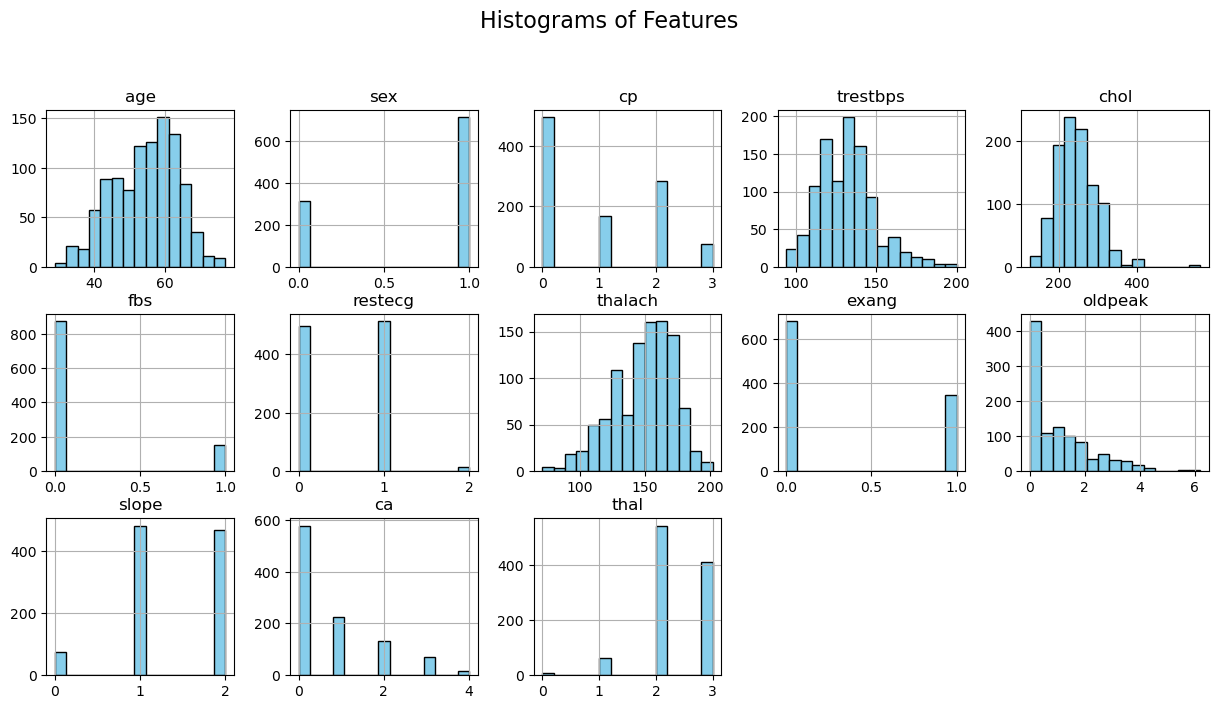

In [ ]:
heart_clev.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(4, 5), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

In [ ]:
binary_features = ["sex", "fbs", "exang"]
continuous_features_standardize = ["age", "trestbps", "chol", "thalach"]
continuous_features_normalize = ["cp", "restecg", "oldpeak", "slope", "ca", "thal"]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = heart_clev[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(heart_clev[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(heart_clev[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = heart_clev['target']

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

In [ ]:
features = processed_data.iloc[:,:-1]
target = processed_data.iloc[:,-1]

In [ ]:
features.describe()

,sex,fbs,exang,age,trestbps,chol,thalach,cp,restecg,oldpeak,slope,ca,thal
count,1025.000000,1025.000000,1025.000000,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,0.695610,0.149268,0.336585,-3.431402e-16,-7.036106e-16,-3.466062e-18,-4.332578e-16,0.314146,0.264878,0.172825,0.692683,0.188537,0.774634
std,0.460373,0.356527,0.472772,1.000488e+00,1.000488e+00,1.000488e+00,1.000488e+00,0.343214,0.263939,0.189525,0.308878,0.257699,0.206887
min,0.000000,0.000000,0.000000,-2.804866e+00,-2.148237e+00,-2.327054e+00,-3.397080e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-7.095548e-01,-6.632165e-01,-6.787242e-01,-7.442713e-01,0.000000,0.000000,0.000000,0.500000,0.000000,0.666667
50%,1.000000,0.000000,0.000000,1.726817e-01,-9.205458e-02,-1.163527e-01,1.255019e-01,0.333333,0.500000,0.129032,0.500000,0.000000,0.666667
75%,1.000000,0.000000,1.000000,7.240794e-01,4.791073e-01,5.623715e-01,7.343432e-01,0.666667,0.500000,0.290323,1.000000,0.250000,1.000000
max,1.000000,1.000000,1.000000,2.488552e+00,3.906079e+00,6.166694e+00,2.299935e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

1    526
0    499
Name: target, dtype: int64


In [ ]:
smote = SMOTE(random_state=4)

features_re, target_re = smote.fit_resample(features,target)

In [ ]:
target_counts = pd.Series(target_re).value_counts()
print(target_counts)

0    526
1    526
Name: target, dtype: int64


In [ ]:
features_re.describe()

,sex,fbs,exang,age,trestbps,chol,thalach,cp,restecg,oldpeak,slope,ca,thal
count,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000
mean,0.698669,0.147338,0.342205,0.014822,0.008775,0.006303,-0.015520,0.311845,0.263034,0.175837,0.689257,0.191770,0.775857
std,0.459054,0.354612,0.474674,0.997796,0.999720,0.997781,0.999498,0.343875,0.264316,0.190327,0.307108,0.257365,0.208640
min,0.000000,0.000000,0.000000,-2.804866,-2.148237,-2.327054,-3.397080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.709555,-0.663216,-0.678724,-0.744271,0.000000,0.000000,0.000000,0.500000,0.000000,0.666667
50%,1.000000,0.000000,0.000000,0.172682,-0.092055,-0.116353,0.125502,0.333333,0.500000,0.129032,0.500000,0.000000,0.666667
75%,1.000000,0.000000,1.000000,0.724079,0.479107,0.581764,0.690855,0.666667,0.500000,0.290323,1.000000,0.250000,1.000000
max,1.000000,1.000000,1.000000,2.488552,3.906079,6.166694,2.299935,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


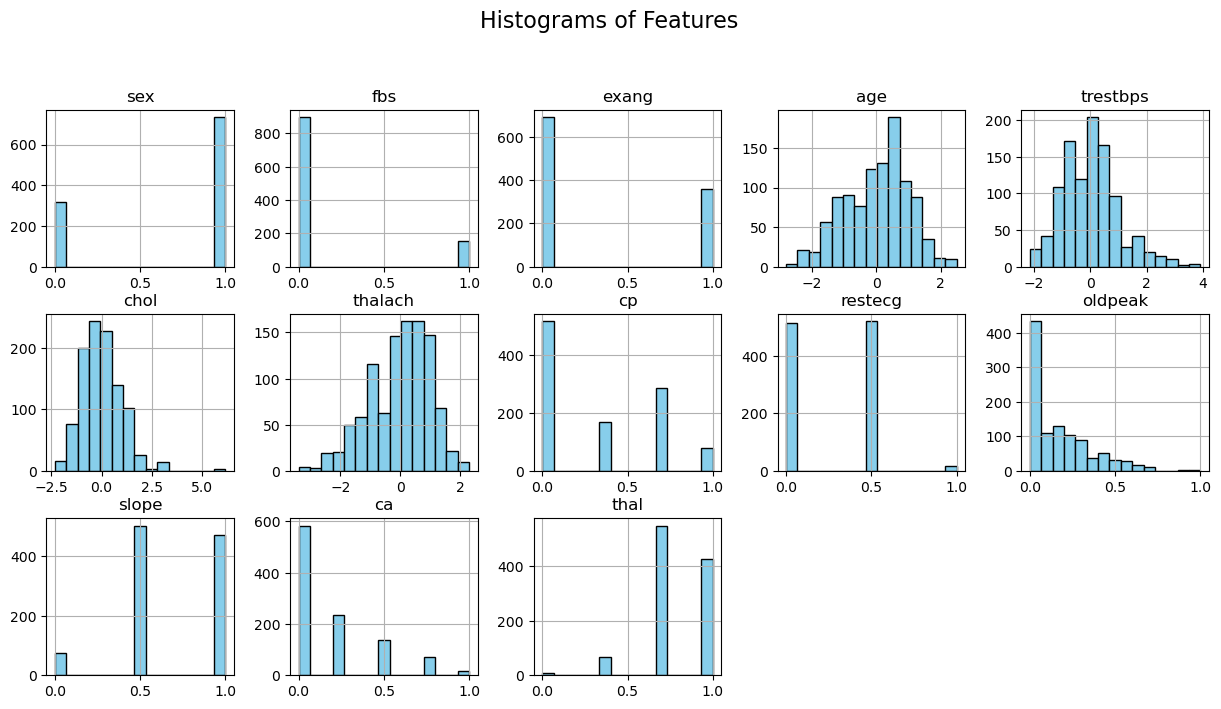

In [ ]:
features_re.hist(bins=15, figsize=(15, 10), layout=(4, 5), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

<Axes: >

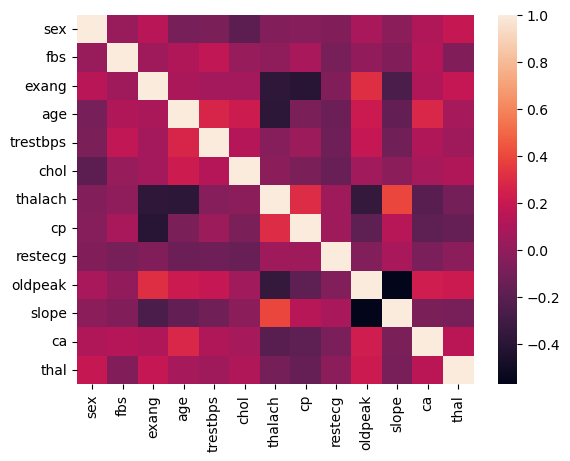

In [ ]:
features_corr = features_re.corr()
sns.heatmap(features_corr)

# Logistic Regression

In [ ]:
results_log_reg_4, acc_log_reg_4 = get_scores(features_re, target_re, splits, clf=LogisticRegression(), clf_name='LogisticRegression', dataset = 'Clevland Heart')


In [ ]:
print(results_log_reg_4)

{'Dataset': 'Clevland Heart', 'Classifier': 'LogisticRegression', 'Train Accuracy': 0.8439578833270934, 'Test Accuracy': 0.8116640191963039}


In [ ]:
print(acc_log_reg_4)

{'20.0% testing split': [[0.8573127229488704, 0.8341232227488151], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '50.0% testing split': [[0.8555133079847909, 0.8288973384030418], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '80.0% testing split': [[0.819047619047619, 0.7719714964370546], {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}]}


# KNN

In [ ]:
results_knn_4, acc_knn_4 = get_scores(features_re, target_re, splits, clf=KNeighborsClassifier(), clf_name= 'KNeighborsClassifier', dataset = 'Clevland Heart')

In [ ]:
print(results_knn_4)

{'Dataset': 'Clevland Heart', 'Classifier': 'KNeighborsClassifier', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9360972878263776}


In [ ]:
print(acc_knn_4)

{'20.0% testing split': [[1.0, 1.0], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}], '50.0% testing split': [[1.0, 0.9543726235741445], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}], '80.0% testing split': [[1.0, 0.8539192399049881], {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}]}


# Decision Tree

In [ ]:
results_dt_4, acc_dt_4 = get_scores(features_re, target_re, splits, clf=DecisionTreeClassifier(), clf_name= 'DecisionTreeClassifier', dataset = 'Clevland Heart')

In [ ]:
print(results_dt_4)

{'Dataset': 'Clevland Heart', 'Classifier': 'DecisionTreeClassifier', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9252503996459632}


In [ ]:
print(acc_dt_4)

{'20.0% testing split': [[1.0, 1.0], {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}], '50.0% testing split': [[1.0, 0.9562737642585551], {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}], '80.0% testing split': [[1.0, 0.8194774346793349], {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}]}


# SVM 

In [ ]:
results_svm_4, acc_svm_4 = get_scores(features_re, target_re, splits, clf=SVC(), clf_name = 'SVM', dataset = 'Clevland Heart')

In [ ]:
print(results_svm_4)

{'Dataset': 'Clevland Heart', 'Classifier': 'SVM', 'Train Accuracy': 1.0, 'Test Accuracy': 0.9265178267689037}


In [ ]:
print(acc_svm_4)

{'20.0% testing split': [[1.0, 1.0], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}], '50.0% testing split': [[1.0, 0.9600760456273765], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}], '80.0% testing split': [[1.0, 0.8194774346793349], {'C': 10, 'gamma': 1, 'kernel': 'rbf'}]}


# Final Data Results

In [ ]:
data_list_res = [results_log_reg_1,
results_knn_1,  
results_dt_1,
results_svm_1,        

results_log_reg_2,
results_knn_2,
results_dt_2,
results_svm_2,

results_log_reg_3,
results_knn_3,
results_dt_3,
results_svm_3,

results_log_reg_4,
results_knn_4,
results_dt_4,
results_svm_4]


In [ ]:
df = pd.DataFrame(data_list_res)
df

,Dataset,Classifier,Train Accuracy,Test Accuracy
0,Heart Failure Clinical Records,LogisticRegression,0.843958,0.811664
1,Heart Failure Clinical Records,KNeighborsClassifier,1.000000,0.936097
2,Heart Failure Clinical Records,DecisionTreeClassifier,1.000000,0.930714
3,Heart Failure Clinical Records,SVM,1.000000,0.926518
4,Heart Data,LogisticRegression,0.848889,0.821667
5,Heart Data,KNeighborsClassifier,1.000000,0.757778
6,Heart Data,DecisionTreeClassifier,0.941944,0.752222
7,Heart Data,SVM,0.915556,0.802500
8,SPECTF,LogisticRegression,0.937178,0.815964
9,SPECTF,KNeighborsClassifier,1.000000,0.775731


C:\Users\jacob\AppData\Local\Temp\ipykernel_25100\1613341722.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


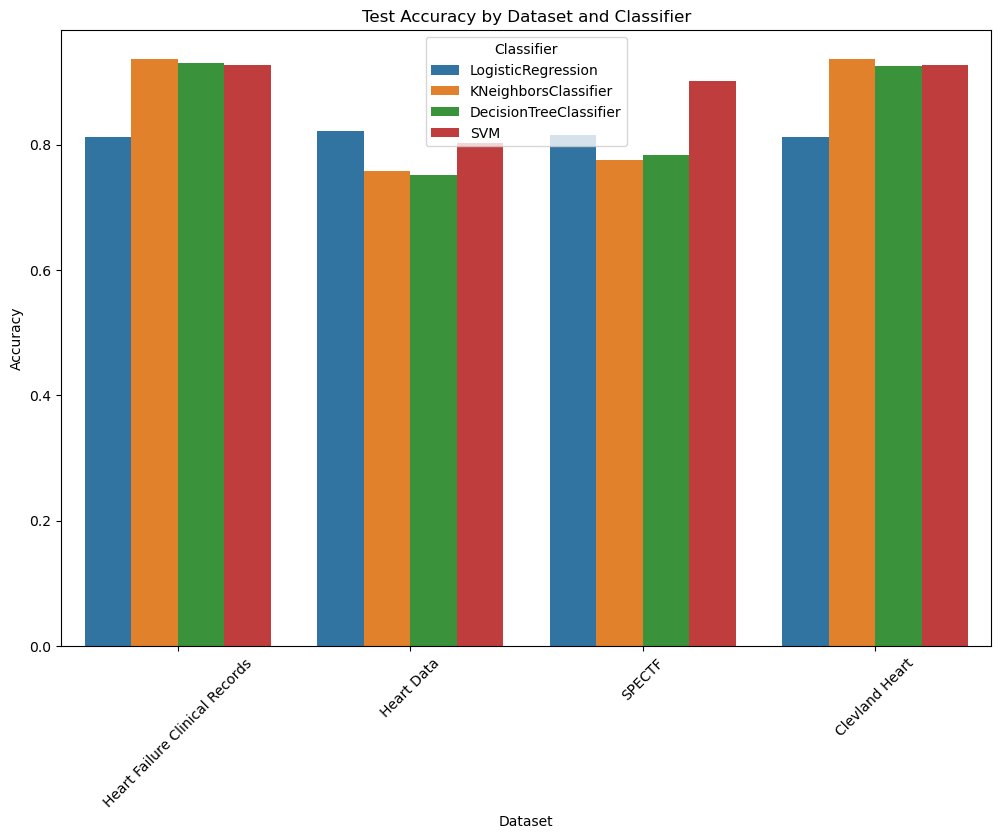

C:\Users\jacob\AppData\Local\Temp\ipykernel_25100\1613341722.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


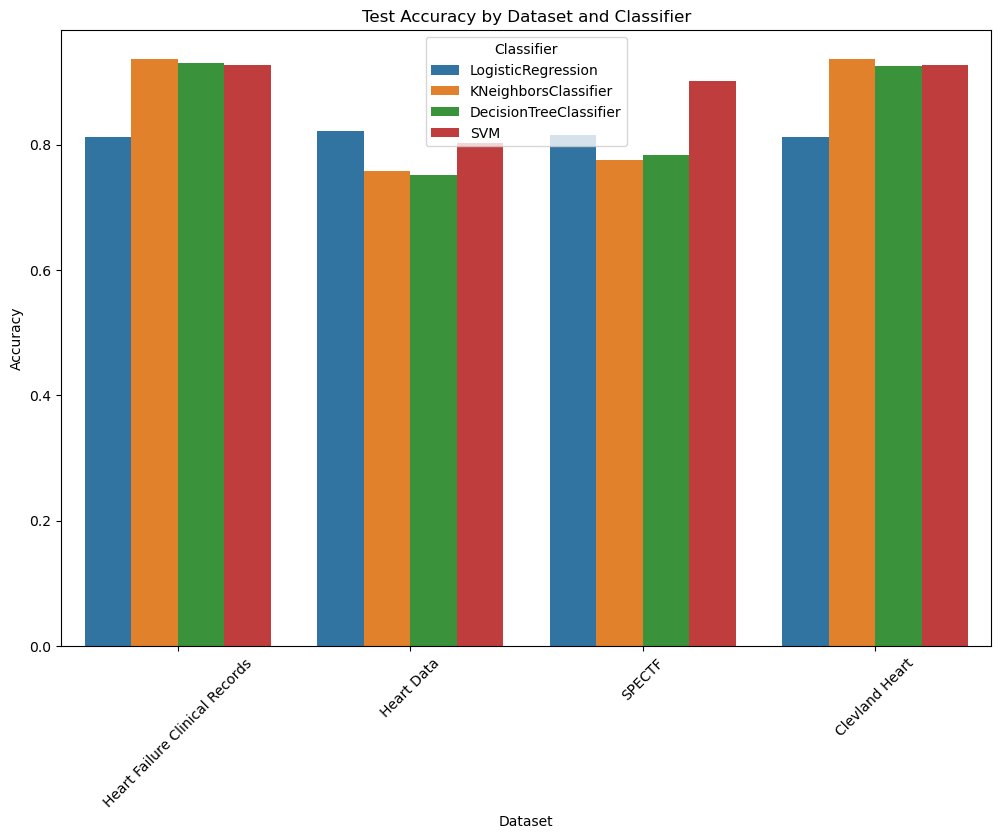

In [ ]:
plt.figure(figsize=(12, 8))

# Create a grouped bar plot for Train Accuracy
sns.barplot(
    data=df,
    x="Dataset",
    y="Test Accuracy",
    hue="Classifier",
    ci=None
)
plt.title("Test Accuracy by Dataset and Classifier")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Classifier")
plt.show()

# Create a grouped bar plot for Test Accuracy
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Dataset",
    y="Test Accuracy",
    hue="Classifier",
    ci=None
)
plt.title("Test Accuracy by Dataset and Classifier")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Classifier")
plt.show()

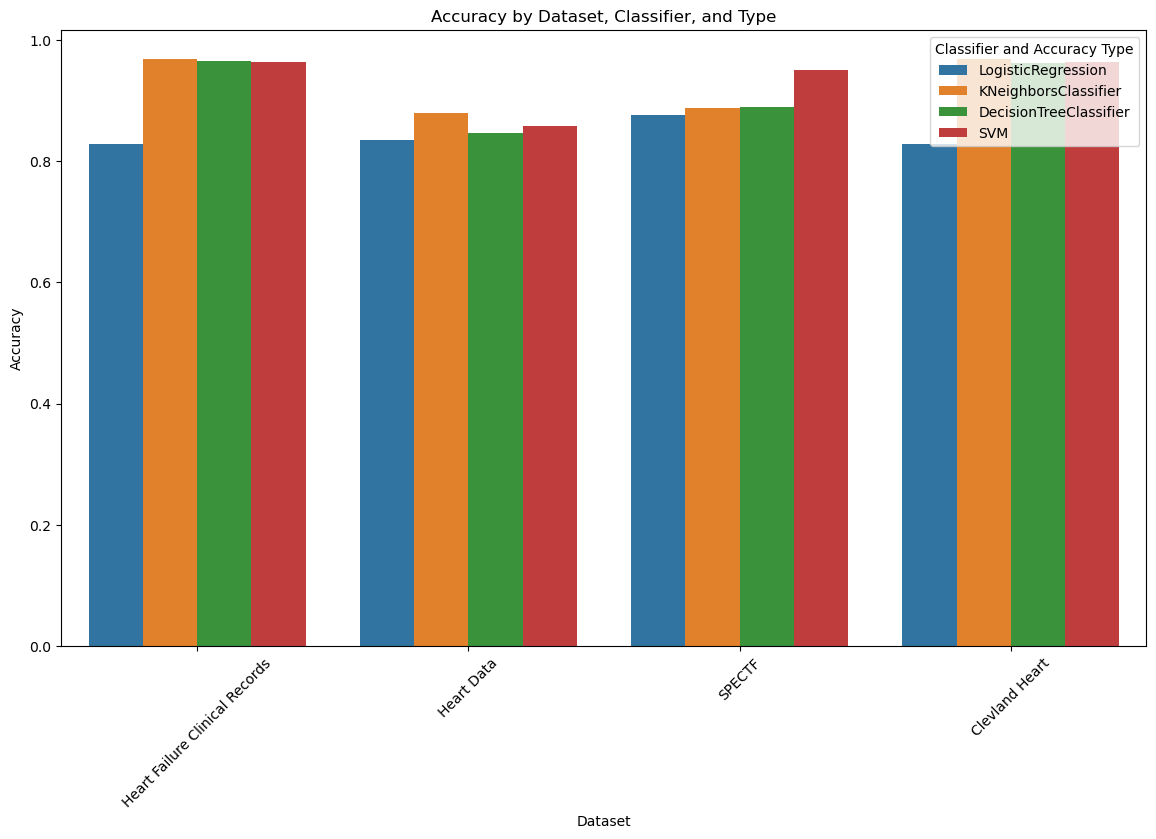

In [ ]:
# Melt the dataframe to create a long-form version
df_melted = df.melt(
    id_vars=["Dataset", "Classifier"],
    value_vars=["Train Accuracy", "Test Accuracy"],
    var_name="Accuracy Type",
    value_name="Accuracy"
)

# Plot both accuracies in one graph
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_melted,
    x="Dataset",
    y="Accuracy",
    hue="Classifier",
    #palette="Accuracy Type",
    errorbar=None
)
plt.title("Accuracy by Dataset, Classifier, and Type")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Classifier and Accuracy Type")
plt.show()

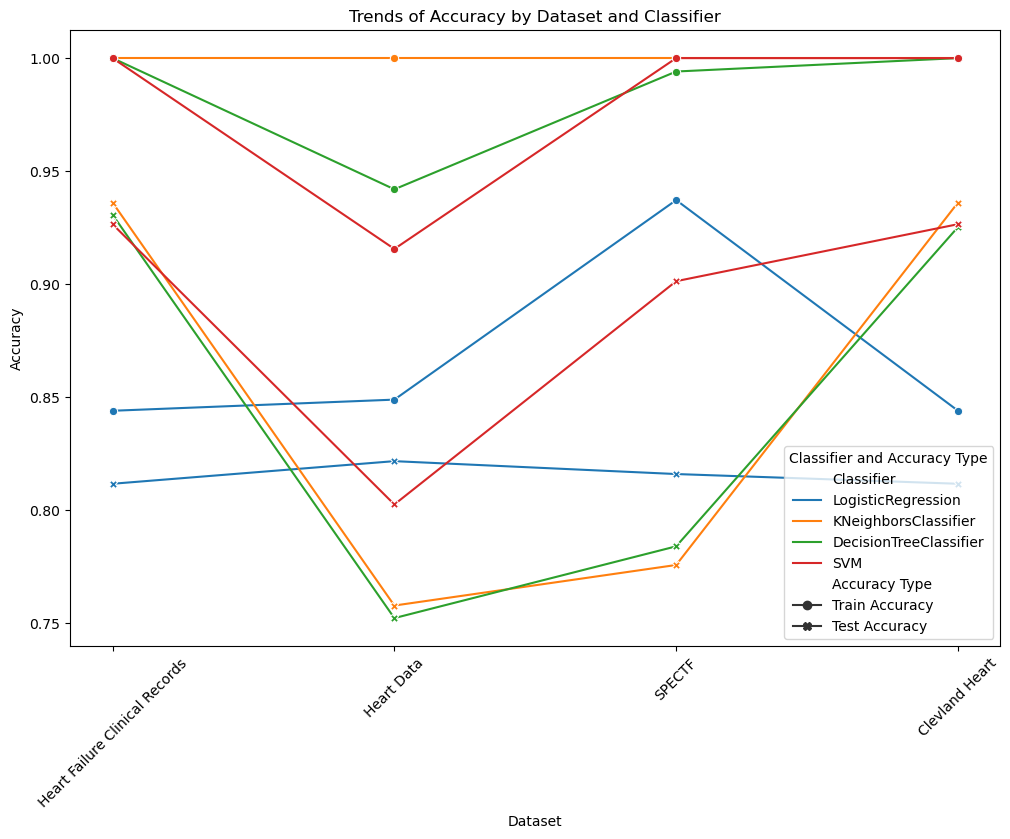

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_melted,
    x="Dataset",
    y="Accuracy",
    hue="Classifier",
    style="Accuracy Type",
    markers=True,
    dashes=False
)
plt.title("Trends of Accuracy by Dataset and Classifier")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Classifier and Accuracy Type")
plt.show()

In [ ]:
pivot_table = df.pivot(index="Classifier", columns="Dataset", values="Test Accuracy")

# Display the pivot table
#print(pivot_table)

# Optional: Format the table for better readability
pivot_table = pivot_table.style.format("{:.2f}").set_caption("Test Accuracy by Classifier and Dataset")
pivot_table

Dataset,Clevland Heart,Heart Data,Heart Failure Clinical Records,SPECTF
Classifier,,,,
DecisionTreeClassifier,0.93,0.75,0.93,0.78
KNeighborsClassifier,0.94,0.76,0.94,0.78
LogisticRegression,0.81,0.82,0.81,0.82
SVM,0.93,0.80,0.93,0.90


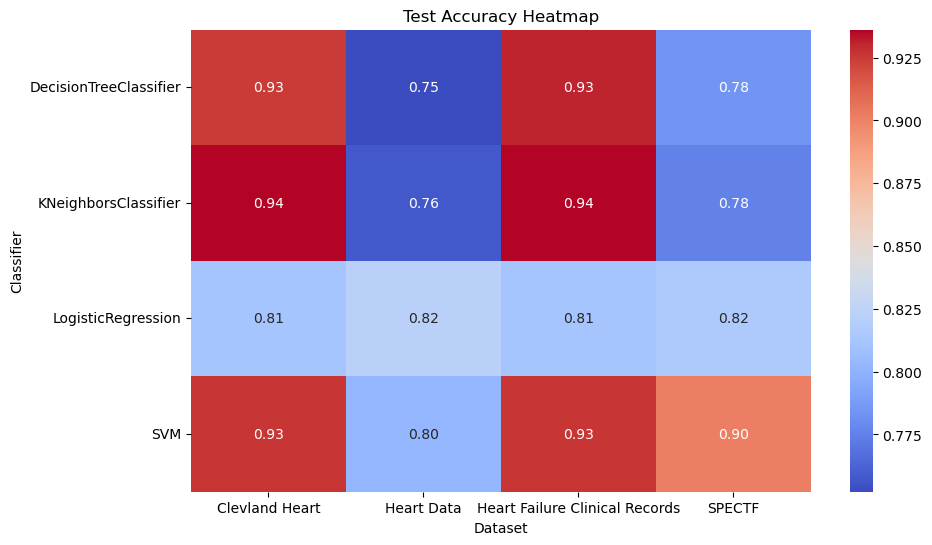

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert pivot_table back to numeric for plotting
pivot_table_numeric = pivot_table.data

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_numeric, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Test Accuracy Heatmap")
plt.xlabel("Dataset")
plt.ylabel("Classifier")
plt.show()

In [ ]:
pivot_table = df.pivot(index="Classifier", columns="Dataset", values="Train Accuracy")

# Display the pivot table
#print(pivot_table)

# Optional: Format the table for better readability
pivot_table = pivot_table.style.format("{:.2f}").set_caption("Training Accuracy by Classifier and Dataset")
pivot_table

Dataset,Clevland Heart,Heart Data,Heart Failure Clinical Records,SPECTF
Classifier,,,,
DecisionTreeClassifier,1.00,0.94,1.00,0.99
KNeighborsClassifier,1.00,1.00,1.00,1.00
LogisticRegression,0.84,0.85,0.84,0.94
SVM,1.00,0.92,1.00,1.00


In [ ]:
list_acc = [acc_log_reg_1,
acc_log_reg_2,
acc_log_reg_3,
acc_log_reg_4,

acc_knn_1,
acc_knn_2,
acc_knn_3,
acc_knn_4,

acc_dt_1,
acc_dt_2,
acc_dt_3,
acc_dt_4,

acc_svm_1,
acc_svm_2,
acc_svm_3,
acc_svm_4]

In [ ]:
print(list_acc[0])

{'20.0% testing split': [[0.8573127229488704, 0.8341232227488151], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '50.0% testing split': [[0.8555133079847909, 0.8288973384030418], {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}], '80.0% testing split': [[0.819047619047619, 0.7719714964370546], {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}]}


In [ ]:
def parse(entry):
    acc, params = entry
    train_acc, test_acc = acc
    return train_acc, test_acc, params

In [ ]:
df_acc = pd.DataFrame(list_acc)
#df_acc

In [808]:
readable = []

for split in ['20.0% testing split', '50.0% testing split', '80.0% testing split']:
    for index, row in df_acc.iterrows():
        entry = row[split]
        train_accuracy, test_accuracy, params = parse(entry)
        readable.append({
            "Split": split,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
            "Parameters": params
        })

readable_df = pd.DataFrame(readable)

In [813]:
readable_df

,Split,Train Accuracy,Test Accuracy,Parameters
0,20.0% testing split,0.857313,0.834123,"{'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}"
1,20.0% testing split,0.866667,0.850000,"{'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}"
2,20.0% testing split,0.932153,0.776471,"{'C': 100, 'max_iter': 2500, 'solver': 'saga'}"
3,20.0% testing split,0.857313,0.834123,"{'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}"
4,20.0% testing split,1.000000,1.000000,"{'leaf_size': 1, 'metric': 'minkowski', 'n_nei..."
5,20.0% testing split,1.000000,0.866667,"{'leaf_size': 1, 'metric': 'minkowski', 'n_nei..."
6,20.0% testing split,1.000000,0.788235,"{'leaf_size': 1, 'metric': 'minkowski', 'n_nei..."
7,20.0% testing split,1.000000,1.000000,"{'leaf_size': 1, 'metric': 'minkowski', 'n_nei..."
8,20.0% testing split,1.000000,1.000000,"{'criterion': 'entropy', 'max_depth': None, 'm..."
9,20.0% testing split,0.879167,0.850000,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."


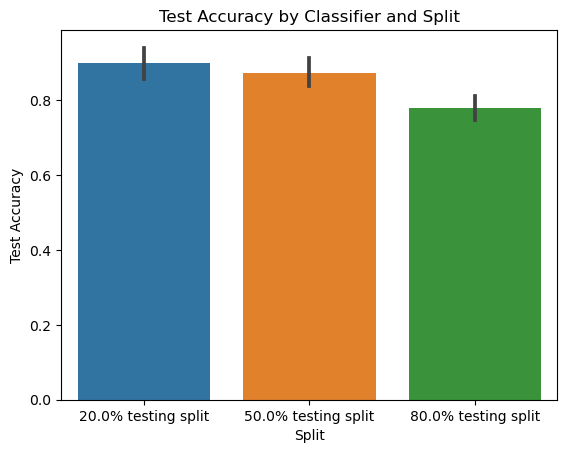

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=readable_df, x="Split", y="Test Accuracy")
plt.title("Test Accuracy by Split")
plt.show()

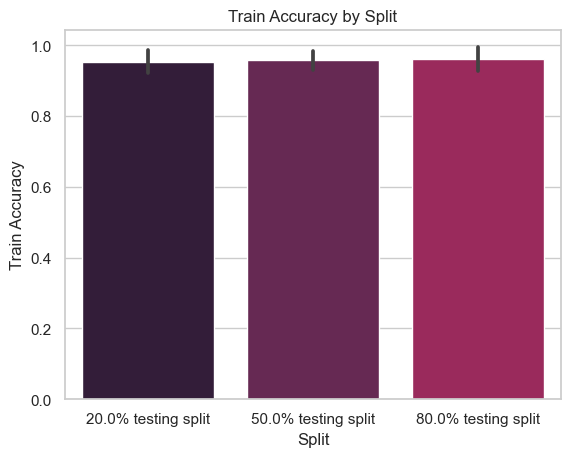

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Setting the theme
sns.set_theme(style="whitegrid", palette="rocket")


sns.barplot(data=readable_df, x="Split", y="Train Accuracy",  ylim=range(pretty(c(0, dat))
plt.title("Train Accuracy by Split")
plt.show()